**CS109A Final Project**<br/>
**Group 12**<br/>
**EDA Page**<br/>

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns; sns.set(color_codes=True)
sns.set(style="whitegrid")

In [3]:
# Load in data
df = pd.read_csv('total_info.csv', encoding = 'latin-1')

In [4]:
# Clean Variables
del df['Unnamed: 0']
df['artist_popularity'] = pd.to_numeric(df['artist_popularity'], errors = 'coerce')
df['artist_followers'] = pd.to_numeric(df['artist_followers'], errors = 'coerce')

In [5]:
# Create pop indicator variable array
pop_ind = []
rap_ind = []
rock_ind = []
for idx, row in enumerate(df['artist_genres'].values):
    if 'pop' in row:
        pop_ind.append(1)
    else:
        pop_ind.append(0)
        
    if 'rap' in row or 'hip' in row:
        rap_ind.append(1)
    else:
        rap_ind.append(0)
        
    if 'rock' in row:
        rock_ind.append(1)
    else:
        rock_ind.append(0)
        
# Append array to dataframe
df['pop_ind'] = pop_ind
df['rap_ind'] = rap_ind
df['rock_ind'] = rock_ind

In [6]:
# Artist Popularity 75% is a 75, use for indicator 
df['artist_popularity'].describe()
df['popular_artist_ind'] = (df['artist_popularity'] >= 75)*1
df.head()

,playlist_id,playlist_name,followers,song_name,number_of_artists,artist_name,artist_id,popularity,track_number,explicit,duration_ms,available_markets,delete,artist_popularity,artist_followers,artist_genres,pop_ind,rap_ind,rock_ind,popular_artist_ind
0,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,18123888.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,88,1,0,197993,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1
1,37i9dQZF1DWXDAhqlN7e6W,This Is: Max Martin,15685.0,Hands To Myself,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,69,3,0,200680,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1
2,37i9dQZF1DX7Q7o98uPeg1,Funkst,397098.0,Good For You - KASBO Remix,3,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,35,3,0,221560,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1
3,37i9dQZF1DX3LyU0mhfqgP,Out Now,439685.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,88,1,0,197993,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1
4,37i9dQZF1DX35oM5SPECmN,HIIT Workout,712771.0,Come & Get It,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,56,1,0,231733,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1


In [7]:
unique_plists = df['playlist_id'].unique()

In [8]:
unique_plists

array(['37i9dQZF1DXcBWIGoYBM5M', '37i9dQZF1DWXDAhqlN7e6W',
       '37i9dQZF1DX7Q7o98uPeg1', ..., '37i9dQZF1DX6kz6Kli3wib',
       '6c51ZkUk7wO3Icy2sW3jvA', '37i9dQZF1DX4IkJGKNp9lO'], dtype=object)

In [9]:
# Sum Up the 100 tracks of info (or less) for each playlist
unique_plists = df['playlist_id'].unique()
columns = ['playlist','name','followers','num_songs','av_song_pop','pct_explicit','avg_dur','av_artist_followers', 'pop_pct', 'rap_pct', 'rock_pct', 'popular_artist_pct']
eda_frame = pd.DataFrame(index=range(0,len(unique_plists)), columns=columns)
for idx,plist in enumerate(unique_plists):
    eda_frame.loc[idx]['playlist'] = plist
    eda_frame.loc[idx]['name'] = df.loc[df['playlist_id'] == plist]['playlist_name']
    eda_frame.loc[idx]['followers'] = np.mean(df.loc[df['playlist_id'] == plist]['followers'])
    eda_frame.loc[idx]['num_songs'] = len(df.loc[df['playlist_id'] == plist])
    eda_frame.loc[idx]['av_song_pop'] = np.mean(df.loc[df['playlist_id'] == plist]['popularity'])
    eda_frame.loc[idx]['pct_explicit'] = np.mean(df.loc[df['playlist_id'] == plist]['explicit'])
    eda_frame.loc[idx]['avg_dur'] = np.mean(df.loc[df['playlist_id'] == plist]['duration_ms'])
    eda_frame.loc[idx]['av_artist_followers'] = np.mean(df.loc[df['playlist_id'] == plist]['artist_followers'])
    eda_frame.loc[idx]['pop_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['pop_ind'])
    eda_frame.loc[idx]['rap_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['rap_ind'])
    eda_frame.loc[idx]['rock_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['rock_ind'])
    eda_frame.loc[idx]['popular_artist_pct'] = np.mean(df.loc[df['playlist_id'] == plist]['popular_artist_ind'])

In [10]:
eda_frame.head()

,playlist,name,followers,num_songs,av_song_pop,pct_explicit,avg_dur,av_artist_followers,pop_pct,rap_pct,rock_pct,popular_artist_pct
0,37i9dQZF1DXcBWIGoYBM5M,0 Today's Top Hits 47 Today's Top H...,1.81239e+07,50,82.38,0.34,208121,2.75535e+06,0.8,0.36,0,1
1,37i9dQZF1DWXDAhqlN7e6W,1 This Is: Max Martin 125 This Is:...,15685,44,55.5227,0.113636,220925,3.99045e+06,0.977273,0.272727,0.227273,0.75
2,37i9dQZF1DX7Q7o98uPeg1,2 Funkst 2500 Funkst 2569 Funks...,397098,100,32.87,0.09,241358,319005,0.12,0.5,0.03,0.08
3,37i9dQZF1DX3LyU0mhfqgP,3 Out Now 48 Out Now 267 Out...,439685,55,71.7273,0.181818,207392,1.02241e+06,0.654545,0.0727273,0.0181818,0.6
4,37i9dQZF1DX35oM5SPECmN,4 HIIT Workout 129 HIIT Workout 48...,712771,50,59.06,0.12,223608,3.32207e+06,0.9,0.24,0.34,0.62


In [11]:
df1 = eda_frame.drop(['playlist', 'name'], axis = 1)

In [12]:
sum(df1['rap_pct'])

219.25442230916607

In [13]:
for i,val in enumerate(df1['followers'].values):
    if df1['followers'][i] != 0:
        df1['followers'][i] = np.log(df1['followers'][i])
    else:
        pass

In [14]:
df1.head()

,followers,num_songs,av_song_pop,pct_explicit,avg_dur,av_artist_followers,pop_pct,rap_pct,rock_pct,popular_artist_pct
0,16.7127,50,82.38,0.34,208121,2.75535e+06,0.8,0.36,0,1
1,9.66046,44,55.5227,0.113636,220925,3.99045e+06,0.977273,0.272727,0.227273,0.75
2,12.8919,100,32.87,0.09,241358,319005,0.12,0.5,0.03,0.08
3,12.9938,55,71.7273,0.181818,207392,1.02241e+06,0.654545,0.0727273,0.0181818,0.6
4,13.4769,50,59.06,0.12,223608,3.32207e+06,0.9,0.24,0.34,0.62


In [15]:
df1['followers'] = pd.to_numeric(df1['followers'], errors='coerce').fillna(0)
df1['num_songs'] = pd.to_numeric(df1['num_songs'], errors='coerce').fillna(0)
df1['av_song_pop'] = pd.to_numeric(df1['av_song_pop'], errors='coerce').fillna(0)
df1['pct_explicit'] = pd.to_numeric(df1['pct_explicit'], errors='coerce').fillna(0)
df1['avg_dur'] = pd.to_numeric(df1['avg_dur'], errors='coerce').fillna(0)
df1['av_artist_followers'] = pd.to_numeric(df1['av_artist_followers'], errors='coerce').fillna(0)
df1['pop_pct'] = pd.to_numeric(df1['pop_pct'], errors='coerce').fillna(0)
df1['rap_pct'] = pd.to_numeric(df1['rap_pct'], errors='coerce').fillna(0)
df1['rock_pct'] = pd.to_numeric(df1['rock_pct'], errors='coerce').fillna(0)
df1['popular_artist_pct'] = pd.to_numeric(df1['popular_artist_pct'], errors='coerce').fillna(0)
df1.dtypes

followers              float64
num_songs                int64
av_song_pop            float64
pct_explicit           float64
avg_dur                float64
av_artist_followers    float64
pop_pct                float64
rap_pct                float64
rock_pct               float64
popular_artist_pct     float64
dtype: object

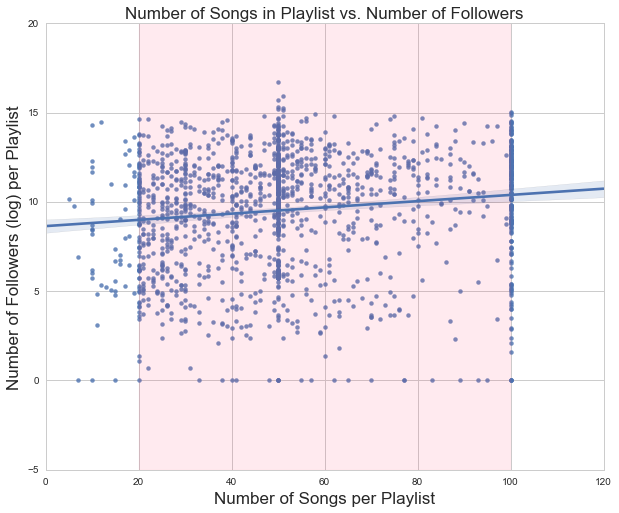

In [16]:
array_vals = df1['num_songs'].values
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(df1['num_songs'], df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('Number of Songs in Playlist vs. Number of Followers', size = 17)
plt.xlabel('Number of Songs per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

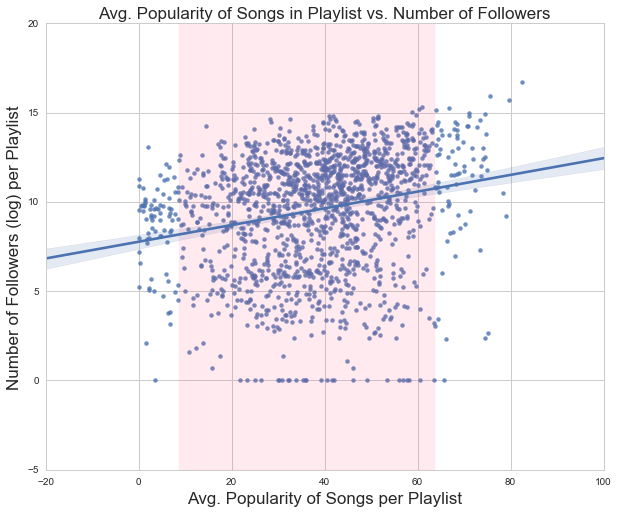

In [18]:
array_vals = df1['av_song_pop'].values
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(df1['av_song_pop'], df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('Avg. Popularity of Songs in Playlist vs. Number of Followers', size = 17)
plt.xlabel('Avg. Popularity of Songs per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

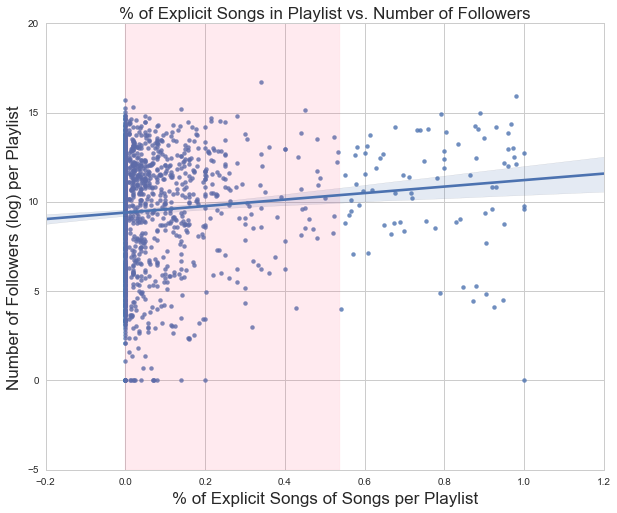

In [19]:
array_vals = df1['pct_explicit'].values
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(df1['pct_explicit'], df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('% of Explicit Songs in Playlist vs. Number of Followers', size = 17)
plt.xlabel('% of Explicit Songs of Songs per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

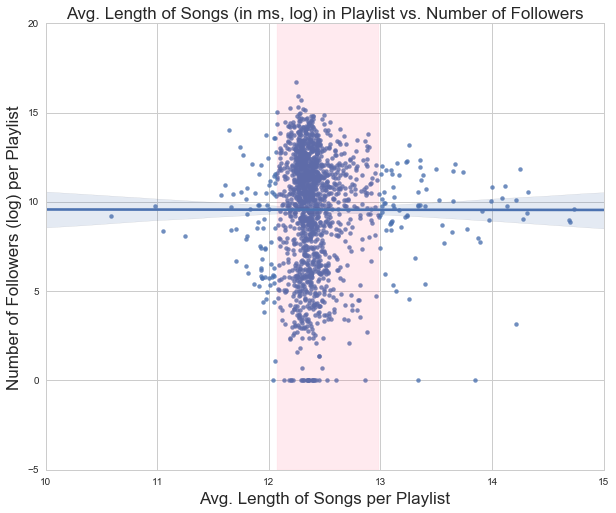

In [20]:
array_vals = np.log(df1['avg_dur'].values)
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(np.log(df1['avg_dur']), df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('Avg. Length of Songs (in ms, log) in Playlist vs. Number of Followers', size = 17)
plt.xlabel('Avg. Length of Songs per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

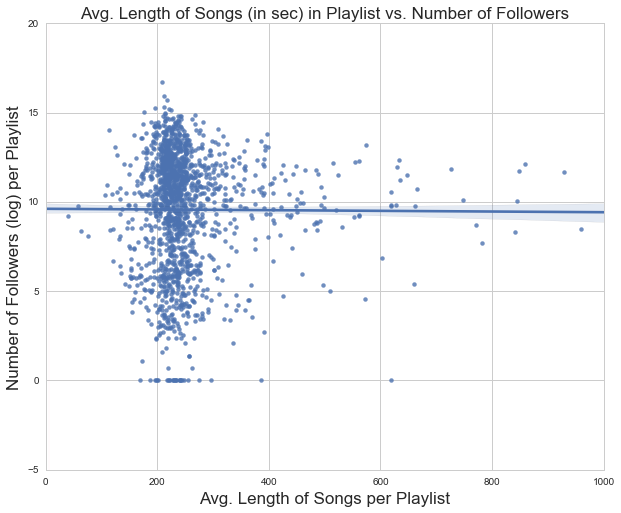

In [21]:
# Alt. version of graph above (CLOSER LOOK)
array_vals = np.log(df1['avg_dur'].values/1000)
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(df1['avg_dur']/1000, df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('Avg. Length of Songs (in sec) in Playlist vs. Number of Followers', size = 17)
plt.xlim(0,1000)
plt.xlabel('Avg. Length of Songs per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

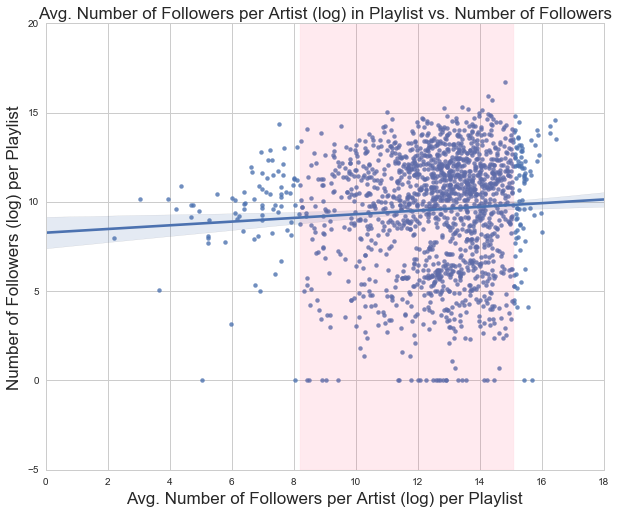

In [22]:
array_vals = np.log(df1['av_artist_followers'].values)
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(np.log(df1['av_artist_followers']), df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('Avg. Number of Followers per Artist (log) in Playlist vs. Number of Followers', size = 17)
plt.xlabel('Avg. Number of Followers per Artist (log) per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

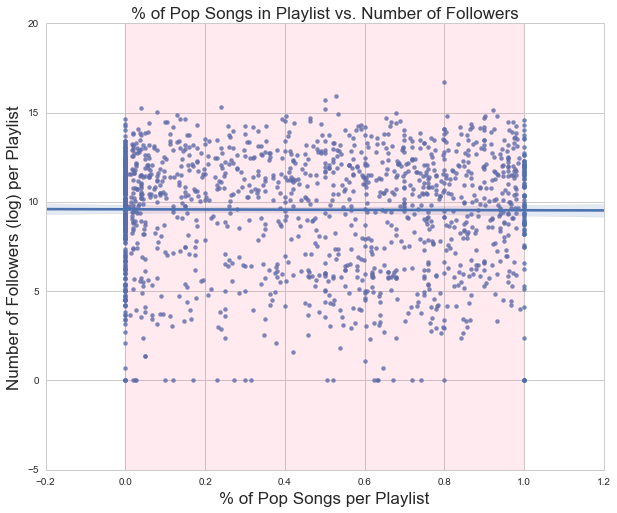

In [23]:
array_vals = df1['pop_pct'].values
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(df1['pop_pct'], df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('% of Pop Songs in Playlist vs. Number of Followers', size = 17)
plt.xlabel('% of Pop Songs per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

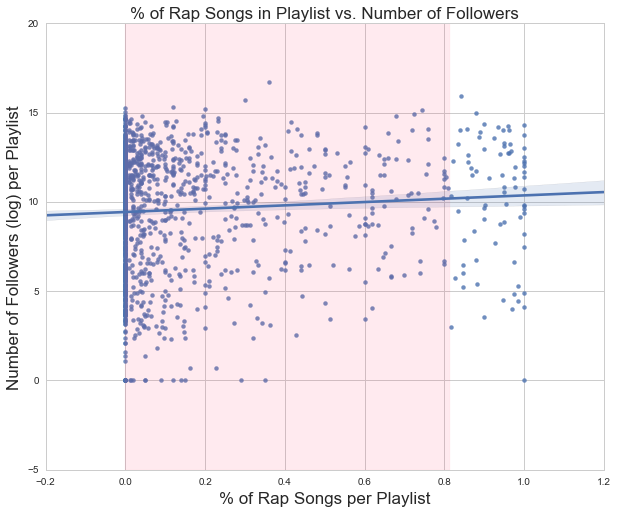

In [24]:
array_vals = df1['rap_pct'].values
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(df1['rap_pct'], df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('% of Rap Songs in Playlist vs. Number of Followers', size = 17)
plt.xlabel('% of Rap Songs per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

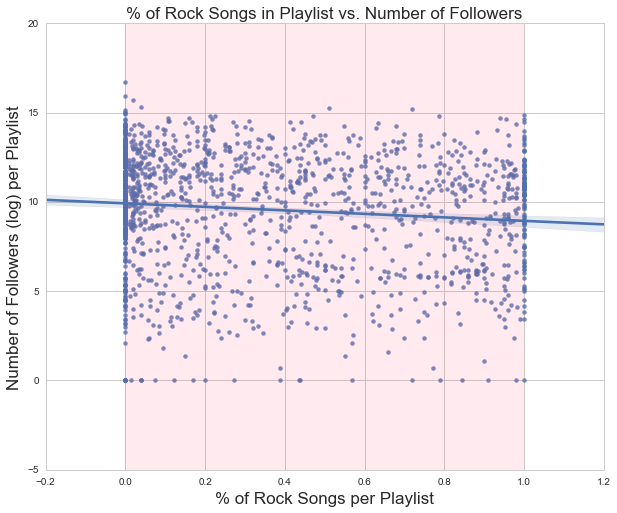

In [25]:
array_vals = df1['rock_pct'].values
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(df1['rock_pct'], df1['followers'])
#plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('% of Rock Songs in Playlist vs. Number of Followers', size = 17)
plt.xlabel('% of Rock Songs per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

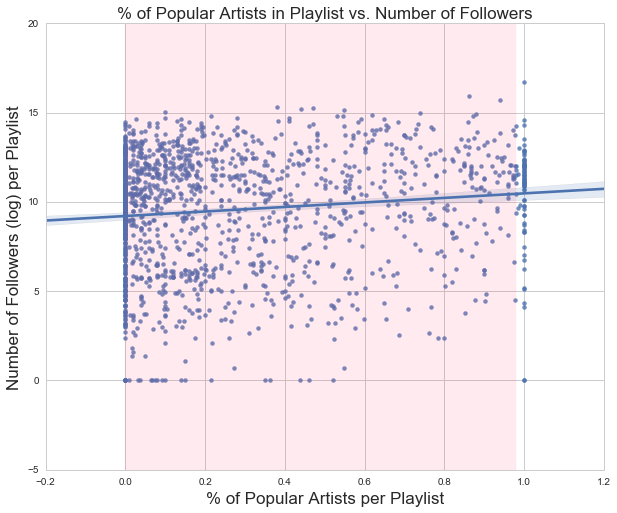

In [26]:
array_vals = df1['popular_artist_pct'].values
lower = np.percentile(array_vals, 5)
upper = np.percentile(array_vals, 95)
plt.figure(figsize = (10,8))
sns.regplot(df1['popular_artist_pct'], df1['followers'])
plt.axvspan(lower, upper, color = (1,.2,.4,0.1))
plt.title('% of Popular Artists in Playlist vs. Number of Followers', size = 17)
plt.xlabel('% of Popular Artists per Playlist', size = 17)
plt.ylabel('Number of Followers (log) per Playlist', size = 17)
plt.show()

In [95]:
fullgenredf = pd.read_csv('PlaylistInfo12-6.csv')
fullgenredf = fullgenredf.drop(fullgenredf.columns[0:2], axis=1)
fullgenredf.columns

Index(['playlist', 'name', 'followers', 'num_songs', 'av_song_pop',
       'pct_explicit', 'avg_dur', 'av_artist_followers', 'pop_pct', 'rap_pct',
       'rock_pct', 'hip_hop_pct', 'country_pct', 'metal_pct', 'indie_folk_pct',
       'rnb_pct', 'edm_pct', 'classical_pct', 'jazz_pct', 'popular_artist_pct',
       'top_3_artist_av_pop', 'top_artist_pop', 'Demi Lovato', 'Lil Wayne',
       'BeyoncÌÄå©', 'Selena Gomez', 'SZA', 'Marshmello', 'Coldplay',
       'Kanye West', 'Kygo', 'Dua Lipa', 'XXXTENTACION', 'Sia',
       'Camila Cabello', 'Migos', 'Gucci Mane', 'Imagine Dragons', 'Rihanna',
       'Travis Scott', 'Maroon 5', 'Taylor Swift', 'The Weeknd',
       'Ty Dolla $ign', 'Nicki Minaj', 'Daddy Yankee', 'Young Thug',
       'Lil Uzi Vert', 'Kendrick Lamar', 'Eminem', 'Chris Brown', 'Future',
       'Justin Bieber', 'J Balvin', 'Sam Smith', '21 Savage', 'Ozuna',
       'Bad Bunny', 'Khalid', 'Ed Sheeran', 'Drake', 'Post Malone'],
      dtype='object')

In [100]:
genrepcts = fullgenredf[[9,10,11,12,13,14,15,16,17,18]]
genrepcts.head()

,rap_pct,rock_pct,hip_hop_pct,country_pct,metal_pct,indie_folk_pct,rnb_pct,edm_pct,classical_pct,jazz_pct
0,0.360000,0.000000,0.120000,0.0,0.000000,0.080000,0.020000,0.220000,0.0,0.00
1,0.272727,0.227273,0.136364,0.0,0.045455,0.000000,0.204545,0.022727,0.0,0.00
2,0.500000,0.030000,0.270000,0.0,0.010000,0.130000,0.030000,0.460000,0.0,0.08
3,0.072727,0.018182,0.018182,0.0,0.000000,0.236364,0.090909,0.200000,0.0,0.00
4,0.240000,0.340000,0.100000,0.0,0.000000,0.400000,0.220000,0.060000,0.0,0.00


In [125]:
test = np.arcsin(np.sqrt(genrepcts))

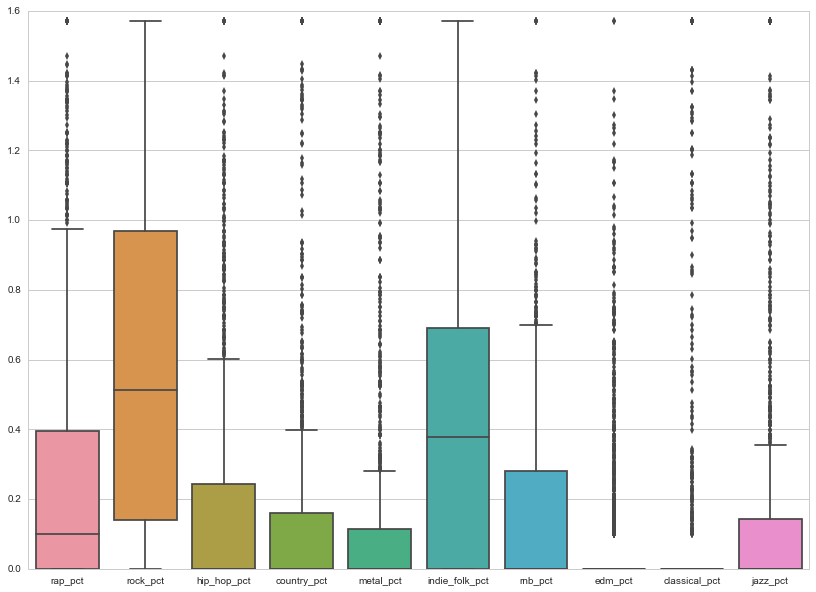

In [126]:
plt.figure(figsize = (14,10))
sns.boxplot(data = test)
#plt.ylim(0,1.003)
plt.show()

In [27]:
df_train = df1.drop('followers', axis = 1)

In [28]:
train_corr_matrix = pd.DataFrame(np.corrcoef(df_train.T))
train_corr_matrix.columns = df_train.columns

In [29]:
train_corr_matrix.index = df_train.columns

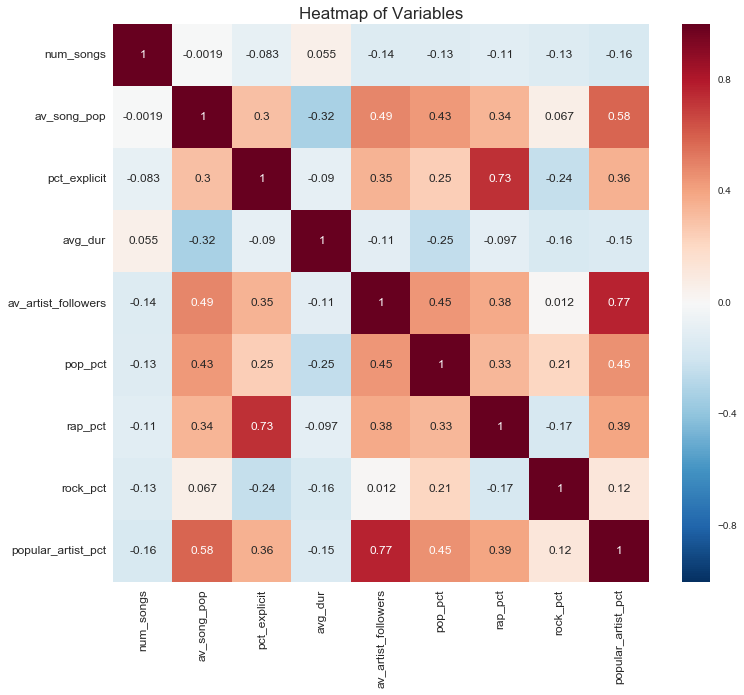

In [55]:
plt.figure(figsize = (12,10))
sns.heatmap(train_corr_matrix,annot=True)
plt.title('Heatmap of Variables', size = 17)
plt.xticks(rotation=90, size = 12) 
plt.yticks(rotation=0, size = 12) 
plt.show()

In [31]:
df.head()

,playlist_id,playlist_name,followers,song_name,number_of_artists,artist_name,artist_id,popularity,track_number,explicit,duration_ms,available_markets,delete,artist_popularity,artist_followers,artist_genres,pop_ind,rap_ind,rock_ind,popular_artist_ind
0,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,18123888.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,88,1,0,197993,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1
1,37i9dQZF1DWXDAhqlN7e6W,This Is: Max Martin,15685.0,Hands To Myself,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,69,3,0,200680,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1
2,37i9dQZF1DX7Q7o98uPeg1,Funkst,397098.0,Good For You - KASBO Remix,3,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,35,3,0,221560,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1
3,37i9dQZF1DX3LyU0mhfqgP,Out Now,439685.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,88,1,0,197993,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1
4,37i9dQZF1DX35oM5SPECmN,HIIT Workout,712771.0,Come & Get It,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,56,1,0,231733,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1


In [32]:
df['count'] = 1

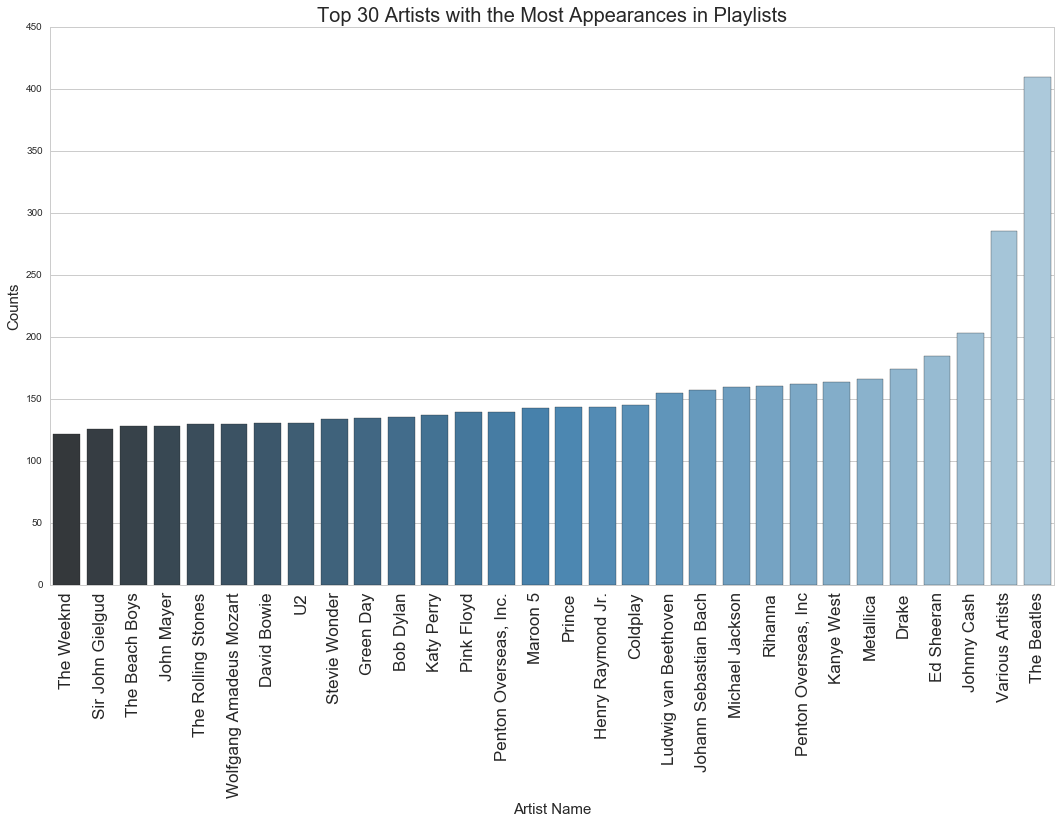

In [33]:
artist_counts = df.groupby('artist_name', as_index=False)['count'].count().sort_values('count', ascending=False)
artist_counts = artist_counts.head(30)
artist_counts = artist_counts.sort_values('count')
plt.figure(figsize = (18,10))
sns.barplot(artist_counts['artist_name'], artist_counts['count'], palette="Blues_d")
plt.xticks(rotation=90, size = 17)
plt.title('Top 30 Artists with the Most Appearances in Playlists', size = 20)
plt.xlabel('Artist Name', size = 15)
plt.ylabel('Counts', size = 15)
plt.show()

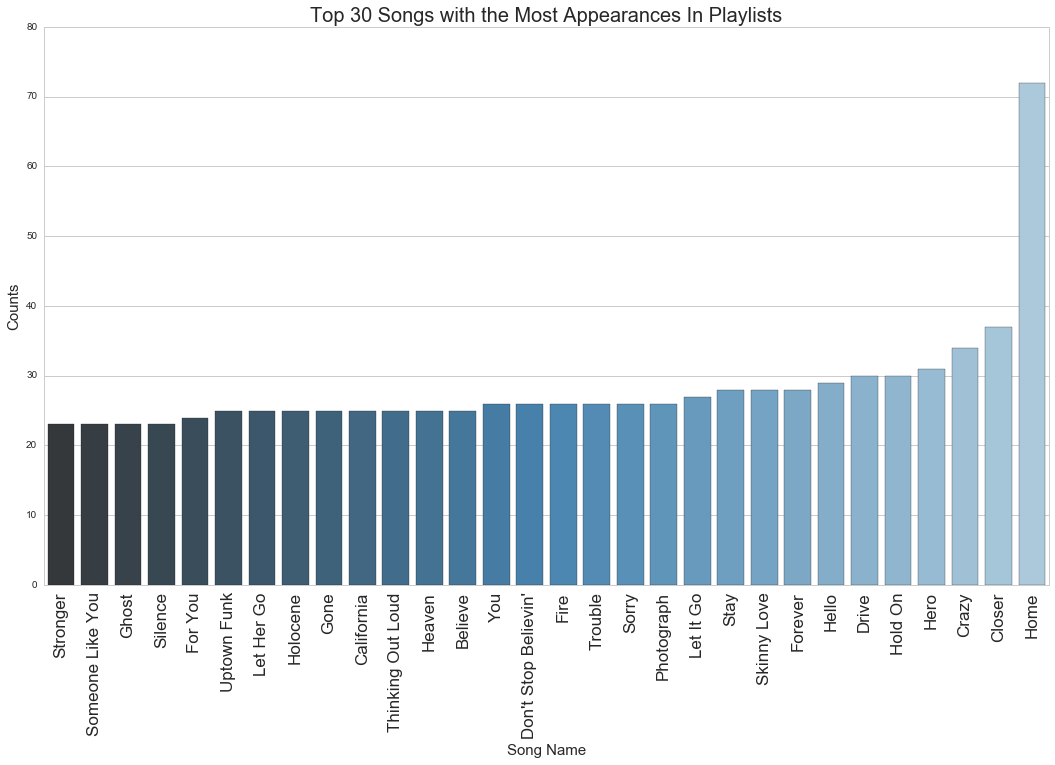

In [35]:
song_counts = df.groupby('song_name', as_index=False)['count'].count().sort_values('count', ascending=False)
song_counts = song_counts.head(30)
song_counts = song_counts.sort_values('count')
plt.figure(figsize = (18,10))
sns.barplot(song_counts['song_name'], song_counts['count'], palette="Blues_d")
plt.xticks(rotation=90, size = 17) 
plt.title('Top 30 Songs with the Most Appearances In Playlists', size = 20)
plt.xlabel('Song Name', size = 15)
plt.ylabel('Counts', size = 15)
plt.show()

In [36]:
df.head()

,playlist_id,playlist_name,followers,song_name,number_of_artists,artist_name,artist_id,popularity,track_number,explicit,...,available_markets,delete,artist_popularity,artist_followers,artist_genres,pop_ind,rap_ind,rock_ind,popular_artist_ind,count
0,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,18123888.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,88,1,0,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
1,37i9dQZF1DWXDAhqlN7e6W,This Is: Max Martin,15685.0,Hands To Myself,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,69,3,0,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
2,37i9dQZF1DX7Q7o98uPeg1,Funkst,397098.0,Good For You - KASBO Remix,3,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,35,3,0,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
3,37i9dQZF1DX3LyU0mhfqgP,Out Now,439685.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,88,1,0,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
4,37i9dQZF1DX35oM5SPECmN,HIIT Workout,712771.0,Come & Get It,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,56,1,0,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1


In [37]:
top100playlists = eda_frame.sort_values("followers", ascending=False).head(150)['playlist'].values

In [38]:
df100 = df[df['playlist_id'].isin(top100playlists)]

In [39]:
df100 = df100.reset_index()
df100

,index,playlist_id,playlist_name,followers,song_name,number_of_artists,artist_name,artist_id,popularity,track_number,...,available_markets,delete,artist_popularity,artist_followers,artist_genres,pop_ind,rap_ind,rock_ind,popular_artist_ind,count
0,0,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,18123888.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,88,1,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
1,4,37i9dQZF1DX35oM5SPECmN,HIIT Workout,712771.0,Come & Get It,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,56,1,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
2,8,37i9dQZF1DX4nYqGKSH0ld,4th of July Party,2687665.0,Bad Liar,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,77,1,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
3,9,37i9dQZF1DX4nYqGKSH0ld,4th of July Party,2687665.0,Kill Em With Kindness,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,70,2,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
4,10,37i9dQZF1DX4WYpdgoIcn6,Chill Hits,1554376.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,93,1,...,[],NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
5,15,37i9dQZF1DWU13kKnk03AP,Daily Lift,977992.0,Wolves,2,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,88,1,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
6,23,37i9dQZF1DWWGeEU3DbvDJ,Billboard Music Awards 2016,695527.0,Kill Em With Kindness,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,70,2,...,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
7,29,37i9dQZF1DWUACcBjzMiIY,Mellow Nights,735011.0,The Heart Wants What It Wants,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,69,1,...,[],NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
8,39,37i9dQZF1DX0Uv9tZ47pWo,Girls' Night,647699.0,Bad Liar,1,Selena Gomez,0C8ZW7ezQVs4URX5aX7Kqx,79,1,...,[],NaN,93.0,6817859.0,"['dance pop', 'pop', 'post-teen pop']",1,0,0,1,1
9,47,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,18123888.0,Let You Down,1,NF,6fOMl44jA4Sp5b9PpYCkzz,61,1,...,[],NaN,90.0,499368.0,[],0,0,0,1,1


In [40]:
for i in range(len(df100['artist_genres'])):
    df100['artist_genres'][i] = df100['artist_genres'][i][1:-1]

In [42]:
testarray = df100['artist_genres']

In [43]:
test = testarray[0].replace(" '", "")
test = test.replace("'", "")
test.split(',')

['dance pop', 'pop', 'post-teen pop']

In [44]:
testarray[0].replace("'", "").split(',')

['dance pop', ' pop', ' post-teen pop']

In [45]:
genreslist = []
for i in testarray:
    test = i.replace(" '", "")
    test = test.replace("'", "")
    genreslist.append(test.split(','))

In [46]:
genredf = pd.DataFrame(genreslist)

In [47]:
genredfstack = pd.DataFrame(genredf.stack())
genredfstack['count'] = 1
genredfstack.replace('', np.nan, inplace=True)
genredfstack.dropna(inplace=True)

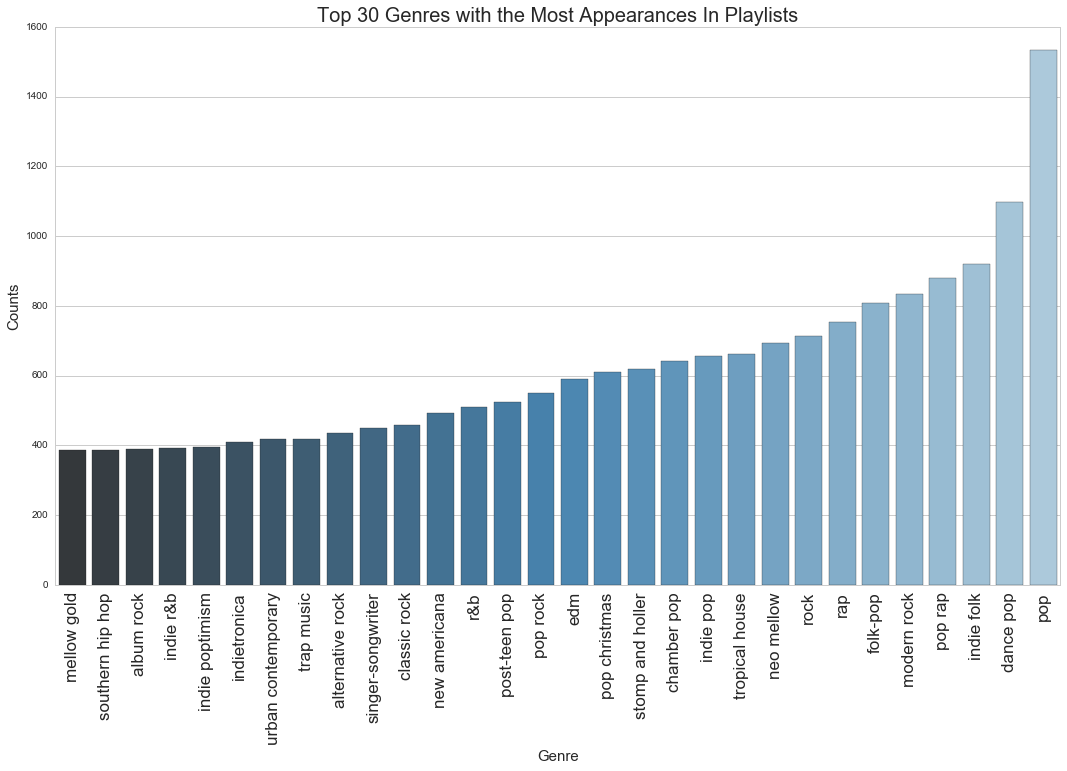

In [48]:
genre_counts = genredfstack.groupby(0, as_index=False)['count'].count().sort_values('count', ascending=False)
genre_counts = genre_counts.head(30)
genre_counts = genre_counts.sort_values('count')
plt.figure(figsize = (18,10))
sns.barplot(genre_counts[0], genre_counts['count'], palette="Blues_d")
plt.xticks(rotation=90, size = 17) 
plt.title('Top 30 Genres with the Most Appearances In Playlists', size = 20)
plt.xlabel('Genre', size = 15)
plt.ylabel('Counts', size = 15)
plt.show()

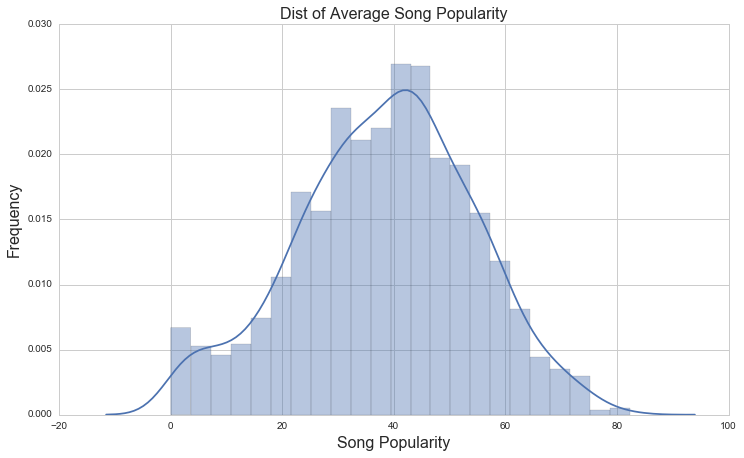

In [138]:
plt.figure(figsize = (12,7))
sns.distplot(df1['av_song_pop'].sort_values())
plt.xlabel("Song Popularity", size = 16)
plt.ylabel("Frequency", size = 16)
plt.title("Dist of Average Song Popularity", size = 16)
plt.show()

In [149]:
eda_frame['log_followers'] = np.log(eda_frame['followers'].astype(float))
eda_frame = eda_frame.dropna(0)
eda_frame = eda_frame.replace([np.inf, -np.inf], 0)
eda_frame['1genre'] = np.where((eda_frame['pop_pct']>=.8)|(eda_frame['rap_pct']>=.8)|(eda_frame['rock_pct']>=.8), 1 , 0)
mixed_genre = eda_frame.loc[eda_frame['1genre'] == 0]
one_genre = eda_frame.loc[eda_frame['1genre'] == 1]

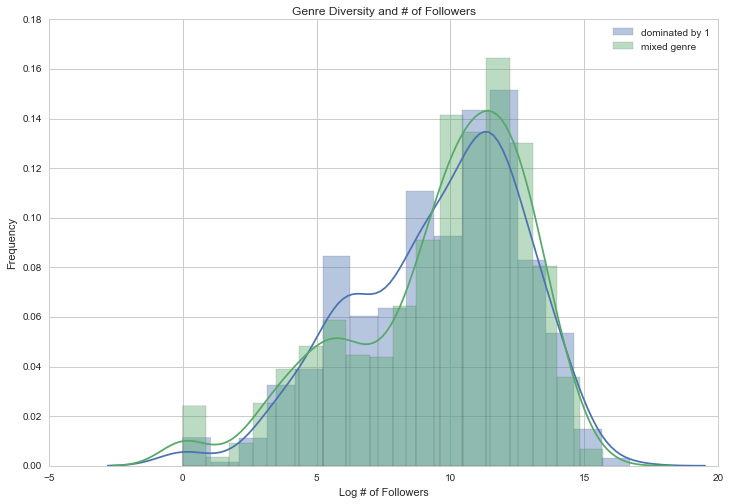

In [154]:
plt.figure(figsize = (12,8))
sns.distplot(one_genre['log_followers'], label='dominated by 1')
sns.distplot(mixed_genre['log_followers'], label='mixed genre')
plt.legend(loc='upper right')
plt.title('Genre Diversity and # of Followers')
plt.ylabel('Frequency')
plt.xlabel('Log # of Followers')
plt.show()